# Building a Random Forest Classifier with Spark in Batch Mode

In this notebook, you'll learn the basics of working with Spark in batch mode to build a random forest classifier. Before digging in, make sure to read the background context in the related reading in the curriculum!

##  Import dependencies

First off, we need to import the tools we'll need from PySpark. The imports below allow us to connect to the Spark server, load our data, clean it, and prepare, execute, and evaluate a model.

In [12]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import isnan, when, count, col

## Set our constants

Next, we create a set of constants that we can refer to throughout the notebook. These are values that the rest of our code needs to run, but that we might need to change at some point (for instance, if the location of our data changes). 

In [13]:
CSV_PATH = "/home/ds/notebooks/datasets/UCI_HAR/allData.csv"
CSV_ACTIVITY_LABEL_PATH = "/home/ds/notebooks/datasets/UCI_HAR/activity_labels.csv"
APP_NAME = "UCI HAR Random Forest Example"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

## Connect to the server and load data

Now we're ready to connect to the Spark server. We do that (relying on the constants set above) and then load our labels (loaded into `activity_labels`) and activity data (loaded into `df`). 

In [14]:
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
activity_labels = spark.read.options(inferschema = "true").csv(CSV_ACTIVITY_LABEL_PATH)
df = spark.read.options(inferschema = "true").csv(CSV_PATH)

In [291]:
activity_labels.show()

+---+------------------+
|_c0|               _c1|
+---+------------------+
|  1|           WALKING|
|  2|  WALKING_UPSTAIRS|
|  3|WALKING_DOWNSTAIRS|
|  4|           SITTING|
|  5|          STANDING|
|  6|            LAYING|
+---+------------------+



In [232]:
# Confirm the dataframe shape is 10,299 rows by 562 columns
print(f"Dataset shape is {df.count():d} rows by {len(df.columns):d} columns.")

Dataset shape is 10299 rows by 562 columns.


In [15]:
# Confirm that all feature columns are doubles via a list comprehension
# We're expecting 561 of 562 here, accounting for the labels column
double_cols = [col[0] for col in df.dtypes if col[1] == 'double']
print(f"{len(double_cols):d} columns out of {len(df.columns):d} total are type double.")

561 columns out of 562 total are type double.


In [16]:
# Confirm there are no null values. We use the dataframe select method to build a 
# list that is then converted to a Python dict. This way it's easy to sum up the nulls.
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
                         for c in df.columns]).toPandas().to_dict(orient='records')

print(f"There are {sum(null_counts[0].values()):d} null values in the dataset.")

There are 0 null values in the dataset.


## Set up and run our classifier in Spark

After confirming our data is clean, we're ready to reshape the data and run the random forest model.

In Spark, we manipulate the data to work in a Spark pipeline, define each of the steps in the pipeline, chain them together, and finally run the pipeline.

Apache Spark classifiers expect 2 columns of input:

1. __labels__: an indexed set of numeric variables that represent the classification from the set of features we provide.
2. __features__: an indexed, vector variable that contains all of the feature values in each row. 

In order to do this, we need to create these 2 columns from our dataset - the data is there, but not yet in a format we can use in the classifier.

To create the indexed labels column, we'll create a column called `indexedLabel` using the `StringIndexer` method. We use the column `_c0` as the source for our label index since that contains our labels. The column contains only one value per index.
    
To create the indexed features column, we'll need to do two things. First, we'll create the vector of features using the `VectorAssembler` method. To create this vector, we'll need to use all 561 numeric columns from our data frame. The vector assembler will create a new column called `features`, and each row of this column will contain a 561-element vector that is built from the 561 features in the dataset.

Finally, we'll complete the data preparation by creating an indexed vector from the `features` column. We'll call this vector `indexedFeatures`.
    
Since the classifier expects indexed labels and an indexed vector column of data, we'll use the `indexedLabel` and `indexedFeatures` as inputs to our random forest classifier.

In [5]:
# Generate our feature vector.
# Note that we're doing the work on the `df` object - we don't create new dataframes, 
# just add columns to the one we already are using.

# the transform method creates the column.

df = VectorAssembler(inputCols=double_cols, outputCol="features").transform(df)

Let's confirm that the features are there. It's easy to do this in Apache Spark using the `select` and `show` methods on the dataframe.  

In [236]:
df.select("_c0", "features").show(5)

+---+--------------------+
|_c0|            features|
+---+--------------------+
|  5|[0.289,-0.0203,-0...|
|  5|[0.278,-0.0164,-0...|
|  5|[0.28,-0.0195,-0....|
|  5|[0.279,-0.0262,-0...|
|  5|[0.277,-0.0166,-0...|
+---+--------------------+
only showing top 5 rows



Now we're ready to build the indexers, split our data for training and testing, define our model, and finally chain everything together into a pipeline.

__It's important to note that when we execute this cell, we're not actually running our model. At this point, we're only defining its parameters__.

In [6]:
# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="_c0", outputCol="indexedLabel").fit(df)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = df.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

This next cell runs the pipeline, delivering a trained model at the end of the process.

In [7]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

It is now easy to test our model and make predictions simply by using the model's `transform` method on the `testData` dataset.

In [8]:
# Make predictions.
predictions = model.transform(testData)

In [248]:
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector(numTopFeatures=2, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="_c0")

chiSq_result = selector.fit(df).transform(df)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
chiSq_result.select('selectedFeatures').show()

ChiSqSelector output with top 2 features selected
+----------------+
|selectedFeatures|
+----------------+
| [0.289,-0.0203]|
| [0.278,-0.0164]|
|  [0.28,-0.0195]|
| [0.279,-0.0262]|
| [0.277,-0.0166]|
| [0.277,-0.0101]|
| [0.279,-0.0196]|
| [0.277,-0.0305]|
| [0.277,-0.0218]|
|[0.281,-0.00996]|
| [0.277,-0.0127]|
| [0.276,-0.0214]|
| [0.278,-0.0204]|
| [0.277,-0.0147]|
|  [0.298,0.0271]|
|  [0.279,-0.023]|
| [0.279,-0.0148]|
|  [0.28,-0.0139]|
| [0.278,-0.0182]|
|  [0.276,-0.017]|
+----------------+
only showing top 20 rows



In [517]:
print((df.count(), len(df.columns)))

(10299, 563)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

X = df.drop('_c0').collect()
y = df.select('_c0').collect()

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples = df.count()
n_features = len(df.columns)
#X = np.c_[X, random_state.randn(n_samples, 20 * n_features)]

In [29]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

In [53]:
from sklearn import svm
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
model = classifier.fit(X_train, y_train)


/usr/local/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


In [54]:
y_score = classifier.decision_function(np.array(X_test))

In [55]:
y_score

array([[  0.        ,  -8.06593401,  -8.81704148,  -3.02769362,
          1.68852273,  -1.18290245],
       [  0.        ,  -1.58915894,  -4.11671021,   1.89102613,
        -17.26945789,  -9.14809811],
       [  0.        ,  -5.31402518,  -9.36347776,  -3.06077441,
         -3.65849343, -12.43264707],
       ...,
       [  0.        ,  -6.54608474,  -9.64039419,  -2.48956662,
         -0.55820812,   0.56239139],
       [  0.        ,  -4.40729047,  -2.67552736,   2.92834597,
        -12.39379049, -10.91168838],
       [  0.        ,  -5.0784634 ,  -5.29070039,   3.20262134,
        -16.69368955, -10.03386208]])

In [56]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


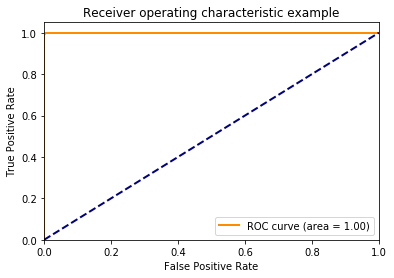

In [57]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

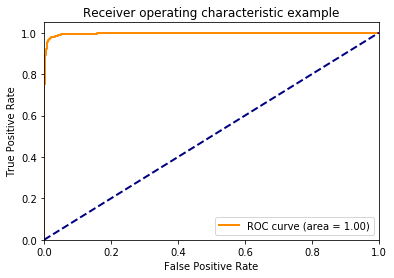

In [62]:
plt.figure()
lw = 2
plt.plot(fpr[4], tpr[4], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [86]:
# confusion_matrix
from sklearn.metrics import confusion_matrix
y_pred=classifier.predict(np.array(X_test))
#confusion_matrix(y_test, y_pred)
confusion_matrix(
    y_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[970,   0,   0,   0,   3,   0],
       [ 12, 824,   0,   0,   0,   0],
       [ 20,   0, 747,   0,   0,   0],
       [ 21,   0,   1, 671,   0,   0],
       [ 60,   0,   0,   0, 815,  20],
       [ 47,   0,   0,   0,  20, 919]])

## Evaluate the model

Now we can use the MulticlassClassificationEvaluator to test the model's accuracy.

In [36]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.0684866
Accuracy = 0.931513


## Next Steps

We've seen how to prepare data and build a classifier in Spark. You might want to play around with this notebook and learn more about how Spark works. Here are some ideas:

- Look at the set of labels, and see if there are any features that would make sense to combine. Spark allows you to map values into a new column.
- Identify the most important features among the 561 source features (using PCA or something similar), then reduce the feature set and see if the model performs better.
- Modify the settings of the random forest to see if the performance improves.
- Use Spark's tools to find other techniques to evaluate the performance of your model. See if you can figure out how to generate an ROC plot, find the AUC value, or plot a confusion matrix.

### PCA

In [141]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

In [185]:
pca = PCA(k=100, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)

result = model.transform(df)
#result.show()

In [186]:
# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="_c0", outputCol="indexedLabel").fit(result)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="pcaFeatures", outputCol="indexedFeatures", maxCategories=4).fit(result)
    
# Split the data into training and validation sets (30% held out for testing)
(pca_trainingData, pca_testData) = result.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [187]:
# Train model.  This also runs the indexers.
pca_model = pipeline.fit(pca_trainingData)

In [188]:
# Make predictions.
pca_predictions = pca_model.transform(pca_testData)

In [189]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pca_predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.180897
Accuracy = 0.819103


As we can see our error and accuracy both suffered after feature reduction so we are loosing some information